<a href="https://www.kaggle.com/code/kusumakar/diabetes-prediction?scriptVersionId=205934744" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-dataset/diabetes_dataset.csv


In [2]:
df=pd.read_csv("/kaggle/input/diabetes-dataset/diabetes_dataset.csv")

In [3]:
df.shape

(768, 9)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check outliers

<Axes: >

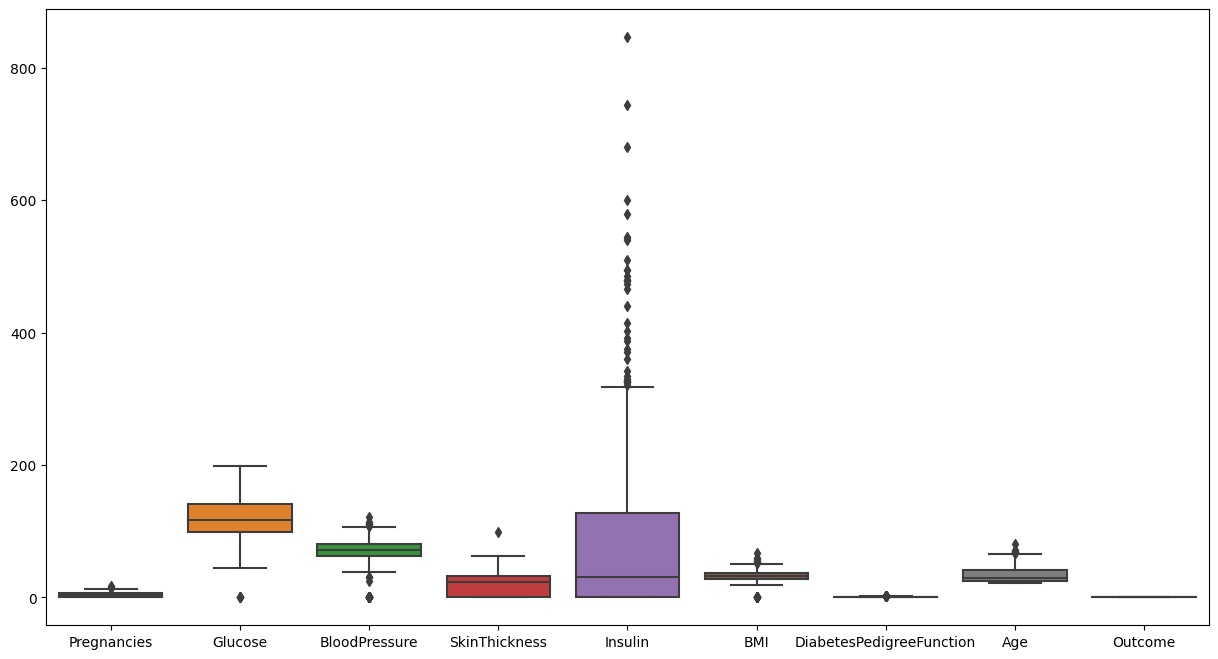

In [6]:
plt.figure(figsize=(15,8))
sns.boxplot(df)

# Remove Outliers

In [7]:
def remove_outliers_iqr(df,column):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Filtering out the rows that are outside of the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Remove outliers
df = remove_outliers_iqr(df,'Glucose')
df = remove_outliers_iqr(df,'BloodPressure')
df = remove_outliers_iqr(df,'SkinThickness')
df = remove_outliers_iqr(df,'Insulin')
df = remove_outliers_iqr(df,'BMI')
df = remove_outliers_iqr(df,'Age')

<Axes: >

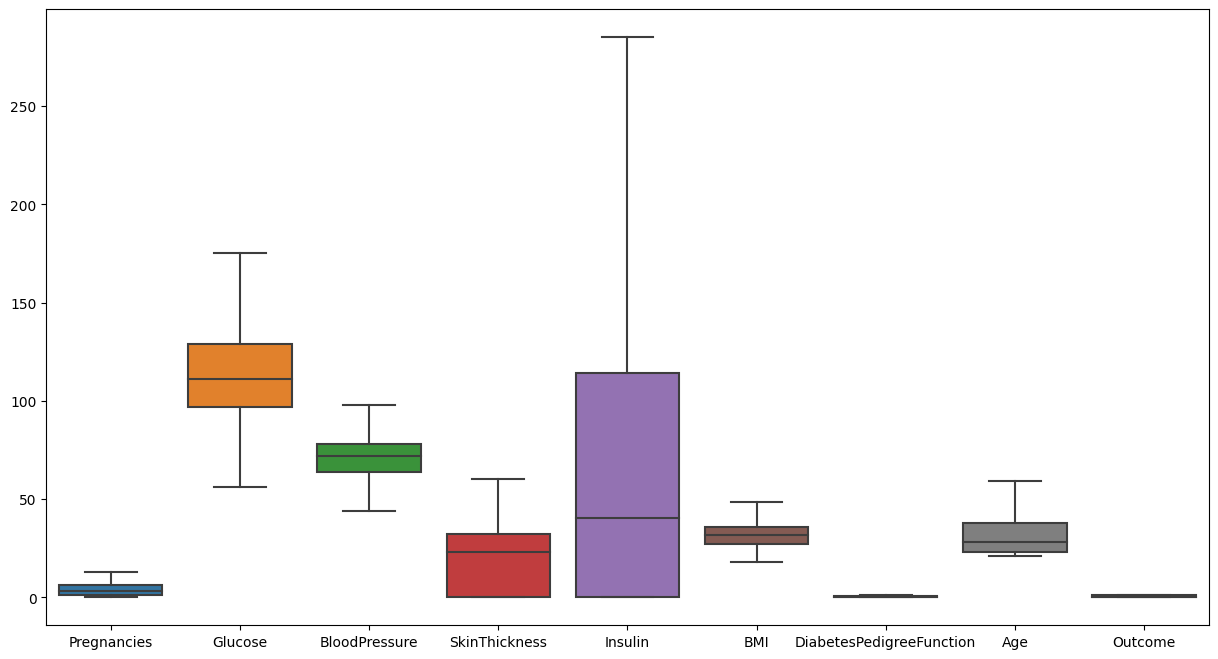

In [8]:
plt.figure(figsize=(15,8))

sns.boxplot(df)

# Check Correlated Features

<Axes: >

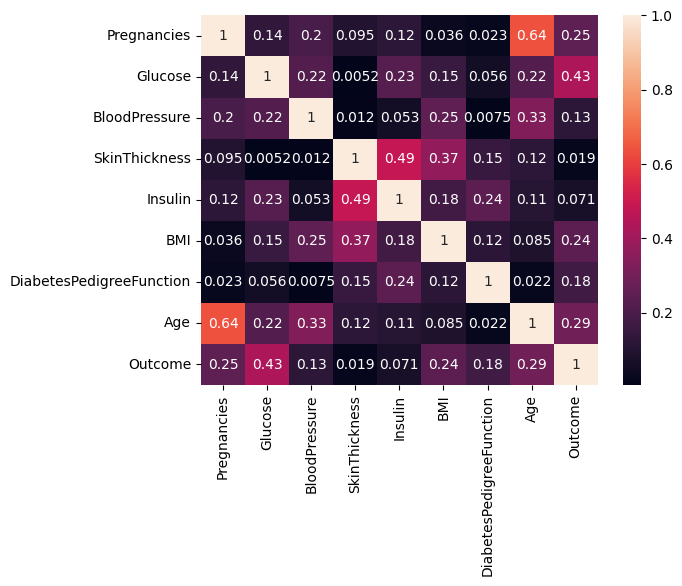

In [9]:
sns.heatmap(df.corr().abs(),annot=True)

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1


# Split dataset to train and test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [12]:
X = df.drop(columns=["Outcome"])
Y= df['Outcome']

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25)

# Upsample minority class

In [14]:
from imblearn.over_sampling import SMOTE
smote= SMOTE()
X_train_upsampled,Y_train_upsampled= smote.fit_resample(X_train,Y_train)

In [15]:
Y_train_upsampled.value_counts()

Outcome
1    303
0    303
Name: count, dtype: int64

# Standardize the values

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

transformer = ColumnTransformer([
    ("scaler",StandardScaler(),list(X_train_upsampled.columns)),

],remainder="passthrough")

In [17]:
X_train_transformed = transformer.fit_transform(X_train_upsampled)
X_test_transformed = transformer.transform(X_test)

In [18]:
X_train_transformed

array([[ 0.62724182, -0.69749674,  1.0908065 , ..., -0.24019653,
        -1.12296832,  0.38563589],
       [-1.2733009 , -0.4995002 , -1.1800605 , ..., -1.00462867,
        -1.33985353, -1.00988067],
       [-0.32302954, -1.29148638, -1.1800605 , ..., -1.80380772,
         0.09528053, -1.22457553],
       ...,
       [ 0.94399894, -0.42030158, -0.35429068, ..., -0.17741017,
         1.52842725,  0.27828846],
       [-1.2733009 , -0.69749674, -0.56073313, ...,  0.32844808,
         0.24875634, -1.1172281 ],
       [ 1.26075606, -1.09348983,  1.0908065 , ...,  0.5106577 ,
         1.19971038,  2.31788959]])

# Model Training and Predictions

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train_transformed,Y_train_upsampled)

RandomForestClassifier()

In [20]:
ypred = rf.predict(X_test_transformed)

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(Y_test,ypred))

0.7769784172661871


In [22]:
print(confusion_matrix(Y_test,ypred))

[[85 19]
 [12 23]]


In [23]:
xg= XGBClassifier()
xg.fit(X_train_transformed,Y_train_upsampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
ypred = xg.predict(X_test_transformed)
print(accuracy_score(Y_test,ypred))

0.7194244604316546


In [25]:
print(confusion_matrix(Y_test,ypred))

[[79 25]
 [14 21]]
